## Notebook 1: Régression de la consommation d'énergie

**1. Prepare Problem**

In [1]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb
from tensorflow import keras
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Dense 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from pickle import dump

import warnings
warnings.filterwarnings("ignore", message="pandas.Int64Index is deprecated")

2023-10-08 10:20:58.551741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# b) Charger l'ensemble de données
# Charger et visualiser chaque fichier de l'ensemble de données
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

L'une des approches de l'optimisation de l'efficacité énergétique des bâtiments consiste à minimiser la consommation totale d'énergie, qui est la somme du chauffage et de la climatisation.

In [3]:
# Calculer la consommation totale d'énergie en additionnant les charges de chauffage et de refroidissement.
data['Energy Consumption'] = data[['Heating Load', 'Cooling Load']].sum(axis=1)
print(data.shape)

# Définir les features et les labels
X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

(768, 11)


**2.Sommaire du Dataset**

In [4]:
# a) Statistiques descriptives
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [5]:
# vérification des features catégorielles
cat_features = data.select_dtypes(include='O').keys()
# affichage
cat_features

Index([], dtype='object')

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


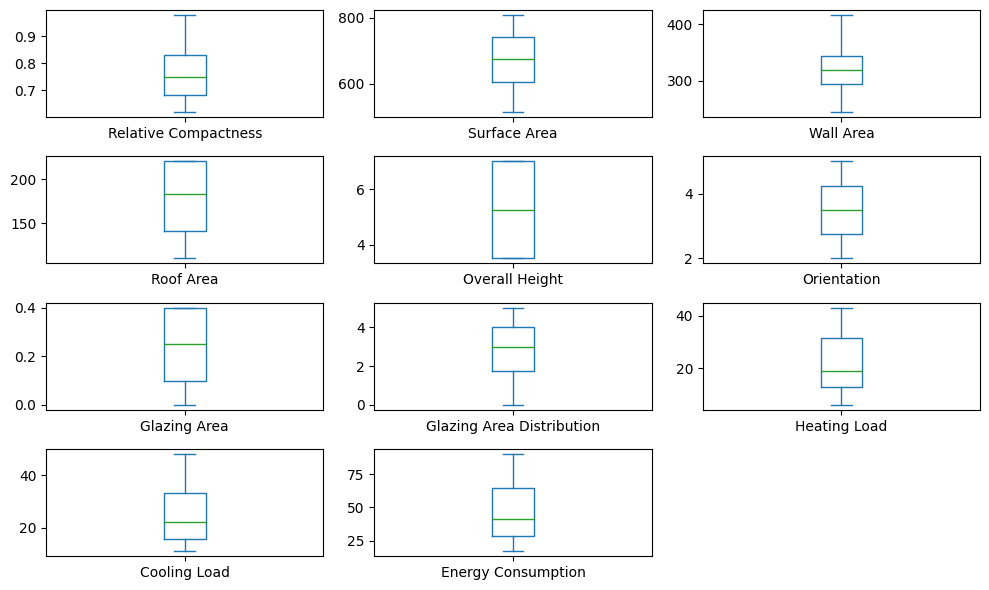

In [6]:
# b) Visualizations des données
# Box et boîte à moustaches (Whisker Plots) de nouvelles features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

Nous pouvons constater que les données sont biaisées vers des valeurs élevées en ce qui concerne la compacité relative, la surface de toit, la surface vitrée et la charge de refroidissement.

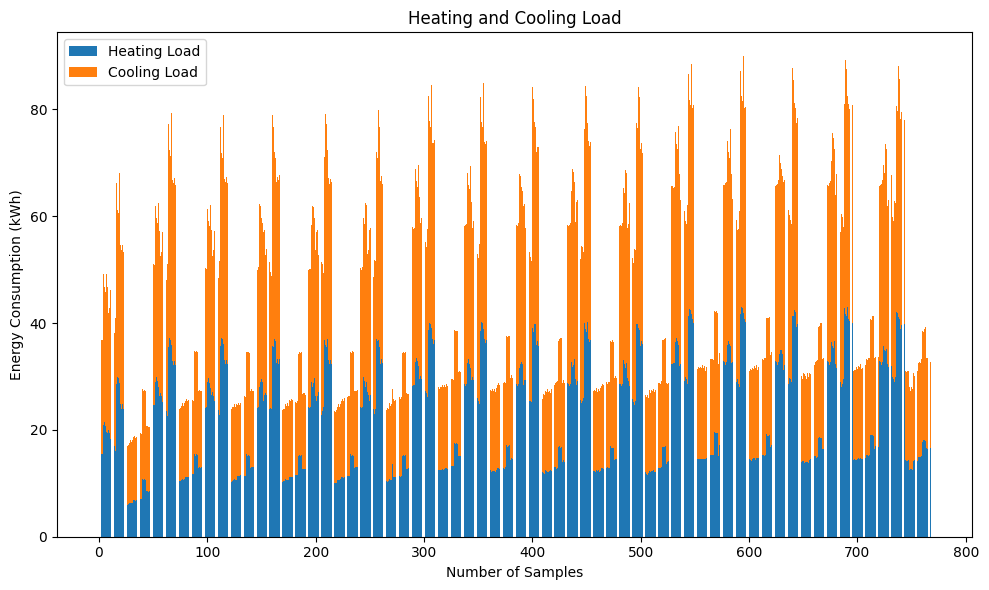

In [7]:
# créer l'histogramme de la charge de chauffage et de refroidissement
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# ajoutde labels, titre et legende
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# afficher le graphique
plt.show()

Les données présentent un schéma cyclique qui peut résulter des mesures prises les jours de semaine (avec des heures plus longues) et les week-ends.

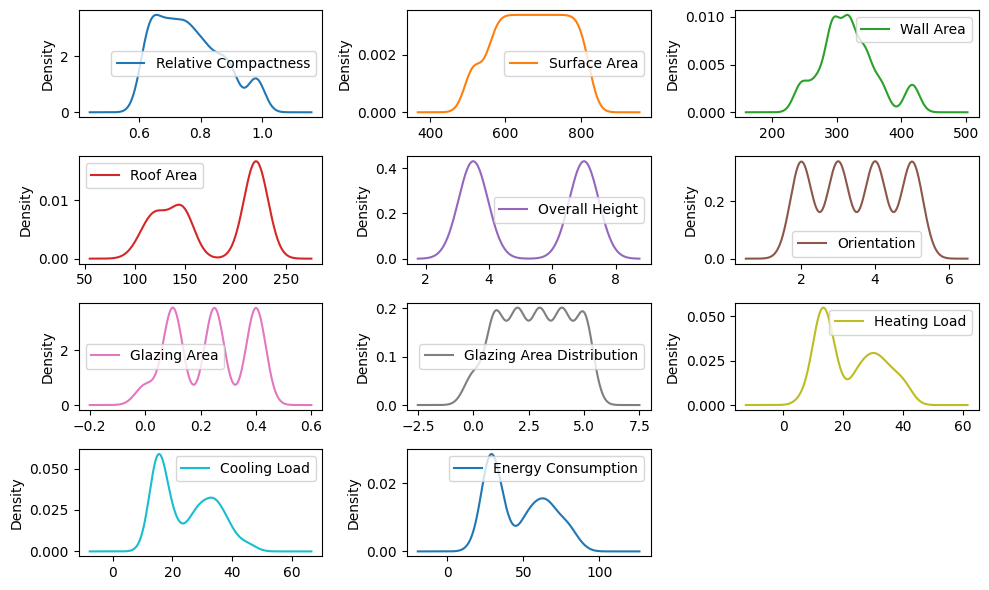

In [8]:
# Créer des diagrammes de densité pour vérifier la distribution gaussienne de features
raw_plot.plot(kind='density', subplots=True, layout=(4,3), sharex=False)
plt.show()

L'ensemble de données semble être complexe car la plupart des caractéristiques présentent des distributions non gaussiennes, à l'exception de la surface. Plusieurs facteurs peuvent être à l'origine de distributions non gaussiennes, notamment les valeurs aberrantes, les erreurs de mesure ou les caractéristiques inhérentes à la conception des bâtiments.

                           Relative Compactness  Surface Area  Wall Area  \
Relative Compactness                  1.000e+00    -9.919e-01 -2.038e-01   
Surface Area                         -9.919e-01     1.000e+00  1.955e-01   
Wall Area                            -2.038e-01     1.955e-01  1.000e+00   
Roof Area                            -8.688e-01     8.807e-01 -2.923e-01   
Overall Height                        8.277e-01    -8.581e-01  2.810e-01   
Orientation                           4.679e-17    -3.459e-17 -2.429e-17   
Glazing Area                         -2.961e-15     3.637e-15 -8.567e-17   
Glazing Area Distribution            -7.107e-16     2.438e-15  2.067e-16   
Heating Load                          6.223e-01    -6.581e-01  4.557e-01   
Cooling Load                          6.343e-01    -6.730e-01  4.271e-01   
Energy Consumption                    6.319e-01    -6.694e-01  4.445e-01   

                           Roof Area  Overall Height  Orientation  \
Relative Compactne

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


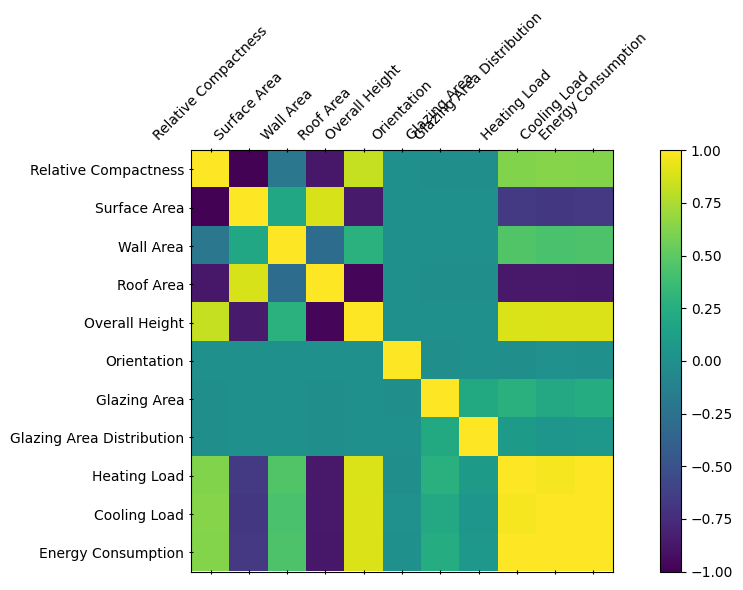

In [9]:
# matrice de corrélation entre toutes les paires d'attributs
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,11))
sub_fig.set_yticks(np.arange(0,11))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

Selon la matrice de corrélation, les charges de chauffage et de refroidissement, ainsi que la consommation d'énergie, présentent de fortes corrélations avec la hauteur totale, l'orientation et, dans une certaine mesure, la surface. L'orientation est considérée comme un facteur incertain dans la conception des bâtiments en raison des choix limités par rapport à d'autres variables, et elle joue un rôle important dans la détermination de l'efficacité énergétique d'un bâtiment.

**3. Preparation des données**

In [10]:
# a) Data Cleaning
# résumer le nombre de valeurs uniques dans chaque colonne
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
Energy Consumption           700
dtype: int64


In [11]:
# Identifier les colonnes avec des valeurs manquantes et compter le nombre de valeurs manquantes
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
Energy Consumption           0
dtype: int64


Il est nécessaire d'éliminer les valeurs aberrantes dans les colonnes de données numériques afin d'améliorer la précision des processus de formation et de validation. Pour ce faire, il convient de déterminer la corrélation entre ces colonnes et la variable cible, d'identifier les colonnes présentant une faible corrélation, puis de filtrer les valeurs qui se situent en dehors des limites inférieures et supérieures.

In [12]:
# calculer la corrélation entre les colonnes numériques et la variable cible
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Energy Consumption']).sort_values(ascending=False)

# filtrer les colonnes à faible corrélation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# supprimer les valeurs aberrantes des colonnes numériques à faible corrélation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [13]:
# b) Diviser l'ensemble de données en ensembles de formation et de validation

X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# Pour le modèle XGBoost
X_train1 = X_train
y_train1 = y_train
X_val1 = X_val

(537, 8) (537,) (231, 8) (231,)


In [14]:
# c) Transformation des données
# Normaliser l'ensemble de données en remettant à l'échelle la distribution des valeurs 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

**4. Evaluation des Algorithmes**

In [15]:
# a) Vérification ponctuelle des algorithmes à l'aide de la technique de validation croisée
num_folds = 8
seed = 8

# Sélectionner les 3 algorithmes les plus populaires pour l'évaluation
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor()))

# Définir le modèle XGBoost
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)
models.append(('XGB', model_xgb))

In [16]:
# Algorithmes de réseaux neuronaux
# créer un modèle séquentiel keras
def baseline_model():
    model = Sequential()
    model.add(Dense(300, input_shape = (8, ), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(200, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(100, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1))
    # Compile le modèle
    model.compile(optimizer = 'adam',
                loss = 'mean_squared_error',
                metrics=['mse'])
    return model

# Construction du modèle
model_NN = baseline_model()
models.append(('NN', model_NN))

2023-10-08 10:21:11.078033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Définir un rappel pour l'arrêt anticipé si la perte de validation ne s'améliore pas pendant 10 années consécutives. 
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
results = []
alg_names = []

# Initialiser l'estimateur KerasRegressor avec un arrêt anticipé
estimator = KerasRegressor(model=model_NN, batch_size=128, verbose=1, callbacks=[early_stopping])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    
    # modifier la boucle pour xgboost et NN
    if name != ('XGB' and 'NN'):
        cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    else:    
        if name == 'NN':
            validation_data = (X_val, y_val)
            cvs = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', fit_params={'validation_data': validation_data, 'epochs': 150})
        else:
            # creation de la DMatrix pour les données d'entrainement de XGBoost
            dtrain = xgb.DMatrix(X_train1, label=y_train1)
            cvs = cross_val_score(model_xgb, X_train1, y_train1, cv=kfold, scoring='neg_mean_squared_error')
    
    results.append(cvs)
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, cvs.mean(), cvs.std())
    print(output)

LR: -31.099568 (9.118195)
RF: -2.999585 (0.962923)
XGB: -3.526021 (1.006473)


INFO:tensorflow:Assets written to: ram://89d1cdab914e4239ae58ff83e76987f3/assets


INFO:tensorflow:Assets written to: ram://89d1cdab914e4239ae58ff83e76987f3/assets


Epoch 1/150


2023-10-08 10:21:15.677297: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a7f208c78d8745ec8a73482bec6dcf08: INVALID_ARGUMENT: ram://a7f208c78d8745ec8a73482bec6dcf08 is a directory.


4/4 [==============================] - 1s 82ms/step - loss: 2477.9639 - mse: 2477.9639 - val_loss: 2745.4307 - val_mse: 2745.4307
Epoch 2/150
4/4 [==============================] - 0s 19ms/step - loss: 2381.5564 - mse: 2381.5564 - val_loss: 2733.5569 - val_mse: 2733.5569
Epoch 3/150
4/4 [==============================] - 0s 19ms/step - loss: 2310.0928 - mse: 2310.0928 - val_loss: 2717.9827 - val_mse: 2717.9827
Epoch 4/150
4/4 [==============================] - 0s 19ms/step - loss: 2278.0166 - mse: 2278.0166 - val_loss: 2699.0620 - val_mse: 2699.0620
Epoch 5/150
4/4 [==============================] - 0s 20ms/step - loss: 2237.7815 - mse: 2237.7815 - val_loss: 2677.1807 - val_mse: 2677.1807
Epoch 6/150
4/4 [==============================] - 0s 19ms/step - loss: 2208.1675 - mse: 2208.1675 - val_loss: 2653.6289 - val_mse: 2653.6289
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 2184.9883 - mse: 2184.9883 - val_loss: 2629.2078 - val_mse: 2629.2078
Epoch 8/150
4/4 [=

4/4 [==============================] - 0s 17ms/step - loss: 264.8389 - mse: 264.8389 - val_loss: 289.7807 - val_mse: 289.7807
Epoch 117/150
4/4 [==============================] - 0s 17ms/step - loss: 259.0818 - mse: 259.0818 - val_loss: 280.2571 - val_mse: 280.2571
Epoch 118/150
4/4 [==============================] - 0s 17ms/step - loss: 243.6519 - mse: 243.6519 - val_loss: 275.1486 - val_mse: 275.1486
Epoch 119/150
4/4 [==============================] - 0s 17ms/step - loss: 249.9486 - mse: 249.9486 - val_loss: 260.5335 - val_mse: 260.5335
Epoch 120/150
4/4 [==============================] - 0s 17ms/step - loss: 209.0709 - mse: 209.0709 - val_loss: 248.3855 - val_mse: 248.3855
Epoch 121/150
4/4 [==============================] - 0s 17ms/step - loss: 214.7891 - mse: 214.7891 - val_loss: 234.4693 - val_mse: 234.4693
Epoch 122/150
4/4 [==============================] - 0s 17ms/step - loss: 203.5530 - mse: 203.5530 - val_loss: 223.7597 - val_mse: 223.7597
Epoch 123/150
4/4 [===============

INFO:tensorflow:Assets written to: ram://19cbf9ac76e347888a370d3e6b21eef4/assets


INFO:tensorflow:Assets written to: ram://19cbf9ac76e347888a370d3e6b21eef4/assets


Epoch 1/150


2023-10-08 10:21:29.649771: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://429f2cb39321439cbb17b991065c7428: INVALID_ARGUMENT: ram://429f2cb39321439cbb17b991065c7428 is a directory.


4/4 [==============================] - 1s 68ms/step - loss: 2467.9260 - mse: 2467.9260 - val_loss: 2747.1882 - val_mse: 2747.1882
Epoch 2/150
4/4 [==============================] - 0s 17ms/step - loss: 2362.9155 - mse: 2362.9155 - val_loss: 2735.5828 - val_mse: 2735.5828
Epoch 3/150
4/4 [==============================] - 0s 18ms/step - loss: 2309.3203 - mse: 2309.3203 - val_loss: 2718.7556 - val_mse: 2718.7556
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 2276.6797 - mse: 2276.6797 - val_loss: 2697.4395 - val_mse: 2697.4395
Epoch 5/150
4/4 [==============================] - 0s 17ms/step - loss: 2234.3755 - mse: 2234.3755 - val_loss: 2673.2644 - val_mse: 2673.2644
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 2214.7351 - mse: 2214.7351 - val_loss: 2646.3999 - val_mse: 2646.3999
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 2189.7878 - mse: 2189.7878 - val_loss: 2619.0400 - val_mse: 2619.0400
Epoch 8/150
4/4 [=

4/4 [==============================] - 0s 18ms/step - loss: 261.7000 - mse: 261.7000 - val_loss: 250.3713 - val_mse: 250.3712
Epoch 117/150
4/4 [==============================] - 0s 16ms/step - loss: 246.4538 - mse: 246.4538 - val_loss: 237.3433 - val_mse: 237.3433
Epoch 118/150
4/4 [==============================] - 0s 17ms/step - loss: 247.5854 - mse: 247.5854 - val_loss: 227.2033 - val_mse: 227.2033
Epoch 119/150
4/4 [==============================] - 0s 17ms/step - loss: 216.1636 - mse: 216.1636 - val_loss: 214.6795 - val_mse: 214.6795
Epoch 120/150
4/4 [==============================] - 0s 17ms/step - loss: 220.1712 - mse: 220.1712 - val_loss: 204.3768 - val_mse: 204.3768
Epoch 121/150
4/4 [==============================] - 0s 17ms/step - loss: 208.6193 - mse: 208.6193 - val_loss: 196.4958 - val_mse: 196.4958
Epoch 122/150
4/4 [==============================] - 0s 17ms/step - loss: 199.1540 - mse: 199.1540 - val_loss: 185.6346 - val_mse: 185.6346
Epoch 123/150
4/4 [===============

INFO:tensorflow:Assets written to: ram://6f093d72f18b41209f540cb292d59e47/assets


INFO:tensorflow:Assets written to: ram://6f093d72f18b41209f540cb292d59e47/assets


Epoch 1/150


2023-10-08 10:21:43.369409: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f3bae042e9f24e57a7035625270287a4: INVALID_ARGUMENT: ram://f3bae042e9f24e57a7035625270287a4 is a directory.


4/4 [==============================] - 1s 68ms/step - loss: 2437.7053 - mse: 2437.7053 - val_loss: 2745.9221 - val_mse: 2745.9221
Epoch 2/150
4/4 [==============================] - 0s 17ms/step - loss: 2332.1335 - mse: 2332.1335 - val_loss: 2732.4780 - val_mse: 2732.4780
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 2269.2393 - mse: 2269.2393 - val_loss: 2717.3696 - val_mse: 2717.3696
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 2227.1055 - mse: 2227.1055 - val_loss: 2698.2793 - val_mse: 2698.2793
Epoch 5/150
4/4 [==============================] - 0s 17ms/step - loss: 2200.9514 - mse: 2200.9514 - val_loss: 2677.5210 - val_mse: 2677.5210
Epoch 6/150
4/4 [==============================] - 0s 16ms/step - loss: 2171.7444 - mse: 2171.7444 - val_loss: 2655.3567 - val_mse: 2655.3567
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 2152.4780 - mse: 2152.4780 - val_loss: 2632.3875 - val_mse: 2632.3875
Epoch 8/150
4/4 [=

4/4 [==============================] - 0s 18ms/step - loss: 256.5659 - mse: 256.5659 - val_loss: 245.7917 - val_mse: 245.7917
Epoch 117/150
4/4 [==============================] - 0s 17ms/step - loss: 242.5058 - mse: 242.5058 - val_loss: 236.5739 - val_mse: 236.5739
Epoch 118/150
4/4 [==============================] - 0s 17ms/step - loss: 230.6171 - mse: 230.6171 - val_loss: 227.2919 - val_mse: 227.2919
Epoch 119/150
4/4 [==============================] - 0s 17ms/step - loss: 234.3200 - mse: 234.3200 - val_loss: 216.9568 - val_mse: 216.9568
Epoch 120/150
4/4 [==============================] - 0s 17ms/step - loss: 219.4889 - mse: 219.4889 - val_loss: 209.1657 - val_mse: 209.1657
Epoch 121/150
4/4 [==============================] - 0s 18ms/step - loss: 215.0116 - mse: 215.0116 - val_loss: 201.1493 - val_mse: 201.1493
Epoch 122/150
4/4 [==============================] - 0s 17ms/step - loss: 205.2374 - mse: 205.2374 - val_loss: 195.5729 - val_mse: 195.5729
Epoch 123/150
4/4 [===============

INFO:tensorflow:Assets written to: ram://adc78a4232154bb8938701e4e31c519d/assets


INFO:tensorflow:Assets written to: ram://adc78a4232154bb8938701e4e31c519d/assets


Epoch 1/150


2023-10-08 10:21:56.799153: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4ae3f7a4759e42f3b277f83a902a7adf: INVALID_ARGUMENT: ram://4ae3f7a4759e42f3b277f83a902a7adf is a directory.


4/4 [==============================] - 1s 68ms/step - loss: 2522.5535 - mse: 2522.5535 - val_loss: 2746.3521 - val_mse: 2746.3521
Epoch 2/150
4/4 [==============================] - 0s 17ms/step - loss: 2435.4536 - mse: 2435.4536 - val_loss: 2733.5784 - val_mse: 2733.5784
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 2375.2014 - mse: 2375.2014 - val_loss: 2718.8735 - val_mse: 2718.8735
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 2338.4768 - mse: 2338.4768 - val_loss: 2701.0027 - val_mse: 2701.0027
Epoch 5/150
4/4 [==============================] - 0s 18ms/step - loss: 2293.4355 - mse: 2293.4355 - val_loss: 2679.4409 - val_mse: 2679.4409
Epoch 6/150
4/4 [==============================] - 0s 18ms/step - loss: 2260.9421 - mse: 2260.9421 - val_loss: 2655.9954 - val_mse: 2655.9954
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 2240.5557 - mse: 2240.5557 - val_loss: 2631.4546 - val_mse: 2631.4546
Epoch 8/150
4/4 [=

4/4 [==============================] - 0s 17ms/step - loss: 286.5980 - mse: 286.5980 - val_loss: 263.6437 - val_mse: 263.6437
Epoch 117/150
4/4 [==============================] - 0s 16ms/step - loss: 273.4073 - mse: 273.4073 - val_loss: 255.8807 - val_mse: 255.8807
Epoch 118/150
4/4 [==============================] - 0s 17ms/step - loss: 267.4187 - mse: 267.4187 - val_loss: 248.5521 - val_mse: 248.5521
Epoch 119/150
4/4 [==============================] - 0s 17ms/step - loss: 238.0894 - mse: 238.0894 - val_loss: 237.6978 - val_mse: 237.6978
Epoch 120/150
4/4 [==============================] - 0s 17ms/step - loss: 234.0437 - mse: 234.0437 - val_loss: 225.1501 - val_mse: 225.1501
Epoch 121/150
4/4 [==============================] - 0s 17ms/step - loss: 221.3799 - mse: 221.3799 - val_loss: 208.9637 - val_mse: 208.9637
Epoch 122/150
4/4 [==============================] - 0s 17ms/step - loss: 206.7530 - mse: 206.7530 - val_loss: 196.9933 - val_mse: 196.9933
Epoch 123/150
4/4 [===============

INFO:tensorflow:Assets written to: ram://d73a7f0c55124556bab5dabc831902ed/assets


INFO:tensorflow:Assets written to: ram://d73a7f0c55124556bab5dabc831902ed/assets


Epoch 1/150


2023-10-08 10:22:10.710445: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://33778abf6e1b47aaa40d4999a4727cd0: INVALID_ARGUMENT: ram://33778abf6e1b47aaa40d4999a4727cd0 is a directory.


4/4 [==============================] - 1s 68ms/step - loss: 2497.7036 - mse: 2497.7036 - val_loss: 2747.7810 - val_mse: 2747.7810
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 2397.4441 - mse: 2397.4441 - val_loss: 2734.2261 - val_mse: 2734.2261
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 2334.9595 - mse: 2334.9595 - val_loss: 2718.4797 - val_mse: 2718.4797
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 2288.6213 - mse: 2288.6211 - val_loss: 2700.1304 - val_mse: 2700.1304
Epoch 5/150
4/4 [==============================] - 0s 17ms/step - loss: 2238.0417 - mse: 2238.0417 - val_loss: 2678.9390 - val_mse: 2678.9390
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 2238.3687 - mse: 2238.3687 - val_loss: 2655.5093 - val_mse: 2655.5093
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 2209.4651 - mse: 2209.4651 - val_loss: 2630.0991 - val_mse: 2630.0991
Epoch 8/150
4/4 [=

4/4 [==============================] - 0s 17ms/step - loss: 256.0103 - mse: 256.0103 - val_loss: 249.5693 - val_mse: 249.5693
Epoch 117/150
4/4 [==============================] - 0s 18ms/step - loss: 245.4011 - mse: 245.4011 - val_loss: 235.0727 - val_mse: 235.0727
Epoch 118/150
4/4 [==============================] - 0s 17ms/step - loss: 249.9424 - mse: 249.9424 - val_loss: 225.2397 - val_mse: 225.2397
Epoch 119/150
4/4 [==============================] - 0s 17ms/step - loss: 246.4423 - mse: 246.4423 - val_loss: 217.8308 - val_mse: 217.8308
Epoch 120/150
4/4 [==============================] - 0s 24ms/step - loss: 225.7772 - mse: 225.7772 - val_loss: 210.9747 - val_mse: 210.9747
Epoch 121/150
4/4 [==============================] - 0s 17ms/step - loss: 231.8618 - mse: 231.8618 - val_loss: 203.2109 - val_mse: 203.2109
Epoch 122/150
4/4 [==============================] - 0s 18ms/step - loss: 210.3252 - mse: 210.3252 - val_loss: 193.4760 - val_mse: 193.4760
Epoch 123/150
4/4 [===============

1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ram://d63dac702815479d8714fd1250ea476b/assets


INFO:tensorflow:Assets written to: ram://d63dac702815479d8714fd1250ea476b/assets


Epoch 1/150


2023-10-08 10:22:24.391090: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5c2f0344ecb64771848196e9248644cb: INVALID_ARGUMENT: ram://5c2f0344ecb64771848196e9248644cb is a directory.


4/4 [==============================] - 1s 70ms/step - loss: 2501.8704 - mse: 2501.8704 - val_loss: 2747.0022 - val_mse: 2747.0022
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 2384.9204 - mse: 2384.9204 - val_loss: 2734.0066 - val_mse: 2734.0066
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 2326.2224 - mse: 2326.2224 - val_loss: 2718.5454 - val_mse: 2718.5454
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 2287.1990 - mse: 2287.1990 - val_loss: 2699.2061 - val_mse: 2699.2061
Epoch 5/150
4/4 [==============================] - 0s 18ms/step - loss: 2252.5383 - mse: 2252.5383 - val_loss: 2676.0525 - val_mse: 2676.0525
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 2226.3621 - mse: 2226.3621 - val_loss: 2651.0791 - val_mse: 2651.0791
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 2215.6375 - mse: 2215.6375 - val_loss: 2623.8760 - val_mse: 2623.8760
Epoch 8/150
4/4 [=

4/4 [==============================] - 0s 17ms/step - loss: 271.2720 - mse: 271.2720 - val_loss: 258.4983 - val_mse: 258.4983
Epoch 117/150
4/4 [==============================] - 0s 18ms/step - loss: 261.7693 - mse: 261.7693 - val_loss: 246.1311 - val_mse: 246.1311
Epoch 118/150
4/4 [==============================] - 0s 16ms/step - loss: 253.6200 - mse: 253.6200 - val_loss: 235.9885 - val_mse: 235.9885
Epoch 119/150
4/4 [==============================] - 0s 17ms/step - loss: 236.7790 - mse: 236.7790 - val_loss: 223.0125 - val_mse: 223.0125
Epoch 120/150
4/4 [==============================] - 0s 18ms/step - loss: 220.6436 - mse: 220.6436 - val_loss: 210.5108 - val_mse: 210.5108
Epoch 121/150
4/4 [==============================] - 0s 18ms/step - loss: 214.6141 - mse: 214.6141 - val_loss: 200.5818 - val_mse: 200.5818
Epoch 122/150
4/4 [==============================] - 0s 18ms/step - loss: 211.0075 - mse: 211.0075 - val_loss: 195.8661 - val_mse: 195.8661
Epoch 123/150
4/4 [===============

1/1 [==============================] - 0s 106ms/step


INFO:tensorflow:Assets written to: ram://10067e3db85b4f43a02ef569ae6a5e95/assets


INFO:tensorflow:Assets written to: ram://10067e3db85b4f43a02ef569ae6a5e95/assets


Epoch 1/150


2023-10-08 10:22:48.524998: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8da98610056649fa92b282be8f9fc819: INVALID_ARGUMENT: ram://8da98610056649fa92b282be8f9fc819 is a directory.


4/4 [==============================] - 1s 68ms/step - loss: 2418.3577 - mse: 2418.3577 - val_loss: 2745.3884 - val_mse: 2745.3884
Epoch 2/150
4/4 [==============================] - 0s 17ms/step - loss: 2309.5325 - mse: 2309.5325 - val_loss: 2733.7532 - val_mse: 2733.7532
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 2250.4421 - mse: 2250.4421 - val_loss: 2719.0967 - val_mse: 2719.0967
Epoch 4/150
4/4 [==============================] - 0s 18ms/step - loss: 2199.1523 - mse: 2199.1523 - val_loss: 2700.6006 - val_mse: 2700.6006
Epoch 5/150
4/4 [==============================] - 0s 17ms/step - loss: 2183.0625 - mse: 2183.0625 - val_loss: 2678.6060 - val_mse: 2678.6060
Epoch 6/150
4/4 [==============================] - 0s 16ms/step - loss: 2144.8547 - mse: 2144.8547 - val_loss: 2652.6953 - val_mse: 2652.6953
Epoch 7/150
4/4 [==============================] - 0s 19ms/step - loss: 2122.7283 - mse: 2122.7283 - val_loss: 2625.7852 - val_mse: 2625.7852
Epoch 8/150
4/4 [=

4/4 [==============================] - 0s 17ms/step - loss: 246.4318 - mse: 246.4318 - val_loss: 287.1128 - val_mse: 287.1128
Epoch 117/150
4/4 [==============================] - 0s 18ms/step - loss: 232.2397 - mse: 232.2397 - val_loss: 276.8553 - val_mse: 276.8553
Epoch 118/150
4/4 [==============================] - 0s 17ms/step - loss: 217.7679 - mse: 217.7679 - val_loss: 267.7480 - val_mse: 267.7480
Epoch 119/150
4/4 [==============================] - 0s 17ms/step - loss: 228.3452 - mse: 228.3452 - val_loss: 258.1409 - val_mse: 258.1409
Epoch 120/150
4/4 [==============================] - 0s 17ms/step - loss: 216.5456 - mse: 216.5456 - val_loss: 245.7985 - val_mse: 245.7985
Epoch 121/150
4/4 [==============================] - 0s 17ms/step - loss: 206.3813 - mse: 206.3813 - val_loss: 230.0406 - val_mse: 230.0406
Epoch 122/150
4/4 [==============================] - 0s 17ms/step - loss: 196.4169 - mse: 196.4169 - val_loss: 218.8024 - val_mse: 218.8024
Epoch 123/150
4/4 [===============

INFO:tensorflow:Assets written to: ram://65cc450d22654ed8acd8700b9951efa0/assets


INFO:tensorflow:Assets written to: ram://65cc450d22654ed8acd8700b9951efa0/assets


Epoch 1/150


2023-10-08 10:23:02.459786: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ef8a3a40db404df8891a44a150acbb12: INVALID_ARGUMENT: ram://ef8a3a40db404df8891a44a150acbb12 is a directory.


4/4 [==============================] - 1s 68ms/step - loss: 2509.5281 - mse: 2509.5281 - val_loss: 2745.9324 - val_mse: 2745.9324
Epoch 2/150
4/4 [==============================] - 0s 17ms/step - loss: 2410.2397 - mse: 2410.2397 - val_loss: 2733.2007 - val_mse: 2733.2007
Epoch 3/150
4/4 [==============================] - 0s 18ms/step - loss: 2328.9946 - mse: 2328.9946 - val_loss: 2717.7927 - val_mse: 2717.7927
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 2298.7170 - mse: 2298.7170 - val_loss: 2698.5027 - val_mse: 2698.5027
Epoch 5/150
4/4 [==============================] - 0s 17ms/step - loss: 2255.6604 - mse: 2255.6604 - val_loss: 2676.8401 - val_mse: 2676.8401
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 2231.6548 - mse: 2231.6548 - val_loss: 2653.0347 - val_mse: 2653.0347
Epoch 7/150
4/4 [==============================] - 0s 18ms/step - loss: 2217.0562 - mse: 2217.0562 - val_loss: 2628.0120 - val_mse: 2628.0120
Epoch 8/150
4/4 [=

4/4 [==============================] - 0s 17ms/step - loss: 270.4687 - mse: 270.4686 - val_loss: 273.9293 - val_mse: 273.9293
Epoch 117/150
4/4 [==============================] - 0s 18ms/step - loss: 249.0799 - mse: 249.0799 - val_loss: 263.5107 - val_mse: 263.5107
Epoch 118/150
4/4 [==============================] - 0s 17ms/step - loss: 247.6427 - mse: 247.6427 - val_loss: 249.0260 - val_mse: 249.0260
Epoch 119/150
4/4 [==============================] - 0s 18ms/step - loss: 238.8855 - mse: 238.8855 - val_loss: 238.1869 - val_mse: 238.1869
Epoch 120/150
4/4 [==============================] - 0s 17ms/step - loss: 221.7915 - mse: 221.7915 - val_loss: 229.8660 - val_mse: 229.8660
Epoch 121/150
4/4 [==============================] - 0s 17ms/step - loss: 216.1384 - mse: 216.1384 - val_loss: 224.0995 - val_mse: 224.0995
Epoch 122/150
4/4 [==============================] - 0s 18ms/step - loss: 206.5858 - mse: 206.5858 - val_loss: 214.1814 - val_mse: 214.1814
Epoch 123/150
4/4 [===============

Epoch 1/500
5/5 [==============================] - 2s 54ms/step - loss: 2476.5710 - mse: 2476.5710 - val_loss: 2746.5222 - val_mse: 2746.5222
Epoch 2/500
5/5 [==============================] - 0s 13ms/step - loss: 2367.0610 - mse: 2367.0610 - val_loss: 2733.2556 - val_mse: 2733.2556
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 2299.4155 - mse: 2299.4155 - val_loss: 2713.8323 - val_mse: 2713.8323
Epoch 4/500
5/5 [==============================] - 0s 13ms/step - loss: 2262.3521 - mse: 2262.3521 - val_loss: 2687.8345 - val_mse: 2687.8345
Epoch 5/500
5/5 [==============================] - 0s 14ms/step - loss: 2223.1953 - mse: 2223.1953 - val_loss: 2658.7603 - val_mse: 2658.7603
Epoch 6/500
5/5 [==============================] - 0s 16ms/step - loss: 2211.2678 - mse: 2211.2678 - val_loss: 2626.1191 - val_mse: 2626.1191
Epoch 7/500
5/5 [==============================] - 0s 17ms/step - loss: 2173.9312 - mse: 2173.9312 - val_loss: 2592.1704 - val_mse: 2592.1704
Epoch 

Epoch 117/500
5/5 [==============================] - 0s 13ms/step - loss: 103.3045 - mse: 103.3045 - val_loss: 94.1828 - val_mse: 94.1828
Epoch 118/500
5/5 [==============================] - 0s 12ms/step - loss: 103.2999 - mse: 103.2999 - val_loss: 87.0818 - val_mse: 87.0818
Epoch 119/500
5/5 [==============================] - 0s 13ms/step - loss: 97.1238 - mse: 97.1238 - val_loss: 78.0962 - val_mse: 78.0962
Epoch 120/500
5/5 [==============================] - 0s 13ms/step - loss: 92.5197 - mse: 92.5197 - val_loss: 71.7593 - val_mse: 71.7593
Epoch 121/500
5/5 [==============================] - 0s 14ms/step - loss: 97.7529 - mse: 97.7529 - val_loss: 70.6136 - val_mse: 70.6136
Epoch 122/500
5/5 [==============================] - 0s 12ms/step - loss: 91.6683 - mse: 91.6683 - val_loss: 71.0905 - val_mse: 71.0905
Epoch 123/500
5/5 [==============================] - 0s 14ms/step - loss: 87.3271 - mse: 87.3271 - val_loss: 72.2862 - val_mse: 72.2862
Epoch 124/500
5/5 [=========================

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


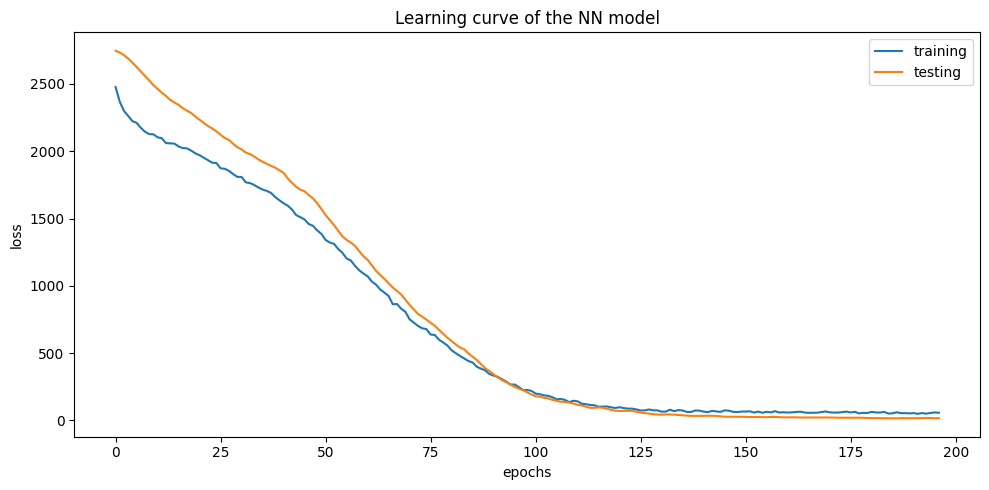

In [19]:
# Tracer la courbe d'apprentissage du modèle NN
history = model_NN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=128, callbacks=[early_stopping])

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve of the NN model')
plt.legend()

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


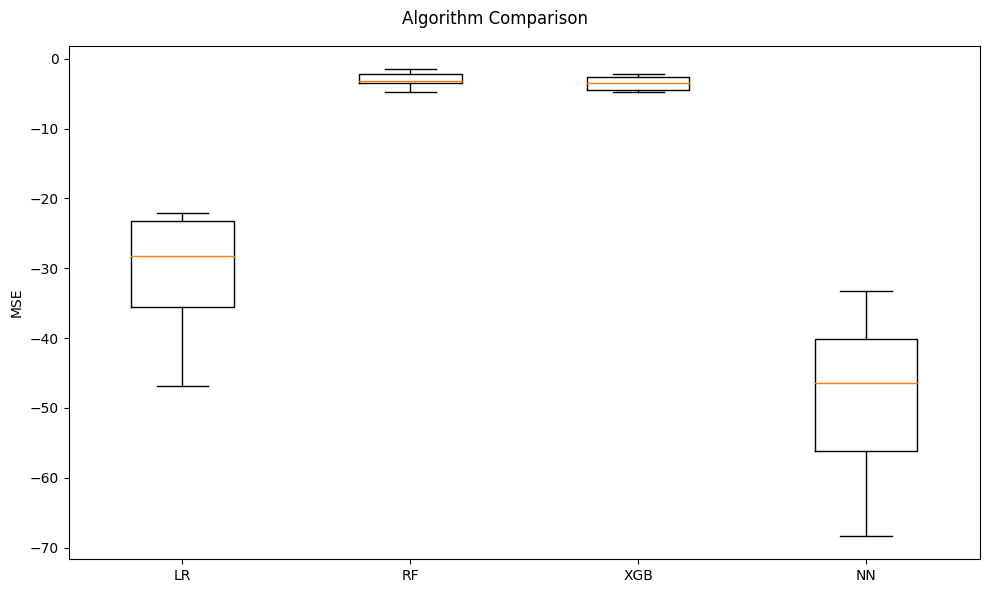

In [20]:
# b) Comparer les algorithmes et le modèle NN
# Distribution des valeurs de précision calculées sur 8 plis de validation croisée.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.ylabel("MSE")
plt.show()

Parmi les trois algorithmes et le modèle NN, les modèles d'ensemble sont plus performants que la régression linéaire et le modèle NN.

Dans un problème de régression, il est courant d'utiliser l'erreur moyenne comme mesure de validation. Pour ce faire, on calcule d'abord l'erreur absolue moyenne (EAM) des données de test par rapport à la moyenne de l'ensemble de données, puis l'EAM des données de test par rapport aux données prédites. 

In [21]:
# Évaluer les performances de l'algorithme Random Forest sur les données de validation
model_RF = RandomForestRegressor(n_estimators=10)
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_val)
mae_pred_RF = mean_absolute_error(y_val, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  1.2476450216450208


In [22]:
# Évaluer les performances de l'algorithme XGBoost sur les données de validation
model_xgb.fit(X_train1, y_train1)
dtrain = xgb.DMatrix(X_val1)
y_pred_xgb = model_xgb.predict(X_val1)
mae_pred_xgb = mean_absolute_error(y_val, y_pred_xgb)
print("Mean Absolute Error of predicted data: ", mae_pred_xgb)

Mean Absolute Error of predicted data:  1.4040925076307158


In [23]:
# Définir la ligne de base de l'erreur moyenne absolue de y_val dans l'ensemble de données
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_val))
mae_ori = mean_absolute_error(y_val, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  17.70811874323593


Les valeurs MAE obtenues montrent que Random Forest semble meilleur que XGBoost en termes de performance de prédiction. Par souci de simplicité, j'ai choisi Random Forest comme modèle de substitution pour le processus d'optimisation dans le 2e Notebook.

**5. Finaliser le modèle**

In [24]:
# a) Obtenir les meilleurs paramètres du modèle
model_params = model_RF.get_params()

# Affichez les paramètres du modèle
print(model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


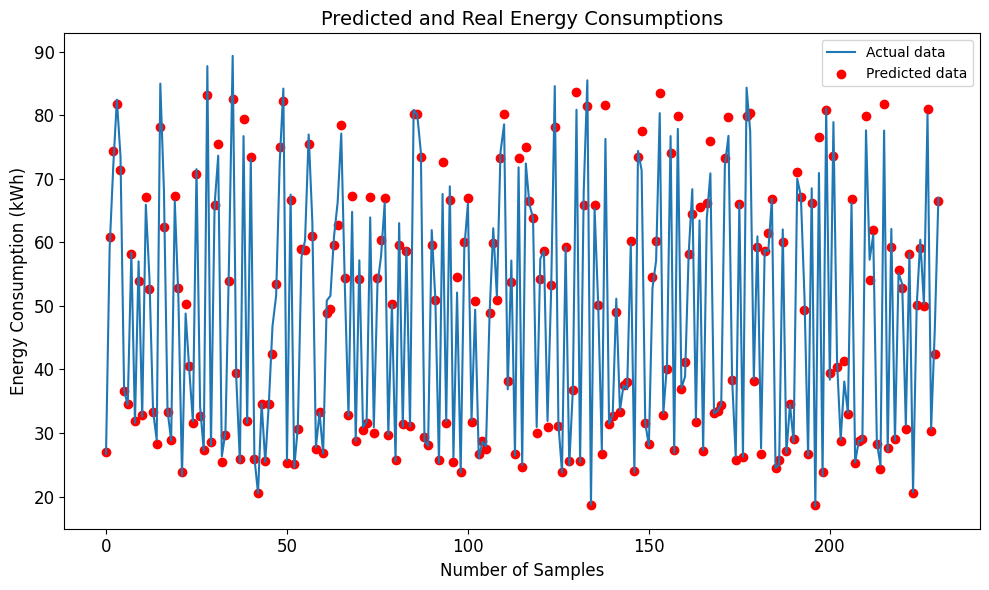

In [25]:
fig, ax = plt.subplots()

# Tracer les données réelles sous la forme d'un graphique linéaire
ax.plot(range(len(y_val)), y_val, label='Actual data')

# Superposer les données prédites sous forme de diagramme de dispersion
ax.scatter(range(len(y_pred_RF)), y_pred_RF, label='Predicted data', color='red')

# Ajouter les labels, titre, et legende
ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=12)
ax.set_title('Predicted and Real Energy Consumptions', fontsize=14)
ax.legend()

# définir la taille de la police de caractères pour les deux axes (tic size)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Afficher le graphique
plt.show()

In [26]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(model_RF, open(filename, 'wb'))

**6. Conclusions**

- L'analyse exploratoire des données montre que la plupart des variables d'entrée présentent une distribution non gaussienne.

- Parmi les trois algorithmes d'apprentissage automatique et le modèle de réseau neuronal (NN), Random Forest et XGBoost ont atteint les valeurs d'erreur quadratique moyenne les plus faibles après le processus de validation croisée. L'algorithme Random Forest a été sélectionné comme modèle de substitution pour le processus d'optimisation dans le 2nd Notebook.

- Les valeurs de l'erreur absolue moyenne indiquent que la précision de prédiction pour les algorithmes d'ensemble est excellente, alors qu'elle est étonnamment faible pour le modèle NN.

- Les performances du modèle NN (Keras Sequential) sont inférieures à celles de tous les algorithmes ML. Un réglage plus poussé de l'hyperparamètre pourrait permettre d'obtenir un meilleur score de prédiction.